# 2A.algo - Plus proches voisins en grande dimension - correction

La méthodes des [plus proches voisins](https://fr.wikipedia.org/wiki/Recherche_des_plus_proches_voisins) est un algorithme assez simple qui devient très lent en grande dimension. Ce notebook propose un moyen d'aller plus vite (ACP) mais en perdant un peu en performance. 

In [1]:
%matplotlib inline

## Q1 : k-nn : mesurer la performance

In [2]:
import time
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

def what_to_measure(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(datax, datay)
    t1 = time.perf_counter()
    y = model.predict(datax)
    t2 = time.perf_counter()
    return t2 - t1, y

In [3]:
dt, y = what_to_measure(2000, 10)
dt

0.32456439999987197

### dimension

In [10]:
nf_set = [10, 20, 50, 100, 200]  # , 200, 500, 1000] # , 2000, 5000, 10000]
Nobs = 500

In [11]:
x = []
y = []
ys = []
for nf in nf_set:
    x.append(nf)
    dt, _ = what_to_measure(Nobs, n_features=nf)
    y.append(dt)
    if nf <= 100:
        dt2, _ = what_to_measure(Nobs, n_features=nf, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nf={0} dt={1} dt2={2}".format(nf, dt, dt2))

nf=10 dt=0.003455999999459891 dt2=0.020609700000022713
nf=20 dt=0.002304800000274554 dt2=0.029963799999677576
nf=50 dt=0.002105900000060501 dt2=0.04159559999970952
nf=100 dt=0.0038469000000986853 dt2=0.06434530000024097
nf=200 dt=0.0027813999995487393 dt2=None


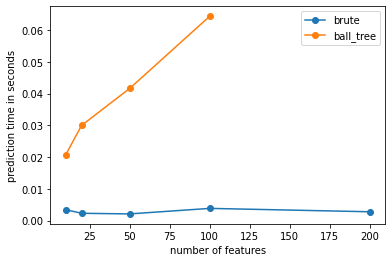

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of features")
ax.set_ylabel("prediction time in seconds")
ax.legend();

### observations

In [13]:
x = []
y = []
ys = []
for nobs in [Nobs // 2, Nobs, Nobs * 2]:
    x.append(nobs)
    dt, _ = what_to_measure(nobs, n_features=200)
    y.append(dt)
    if nobs <= 5000:
        dt2, _ = what_to_measure(nobs, n_features=200, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nobs={0} dt={1} dt2={2}".format(nobs, dt, dt2))

nobs=250 dt=0.0033596000002944493 dt2=0.029927999999927124
nobs=500 dt=0.0036015000005136244 dt2=0.10796130000017001
nobs=1000 dt=0.00941289999991568 dt2=0.3117673000006107


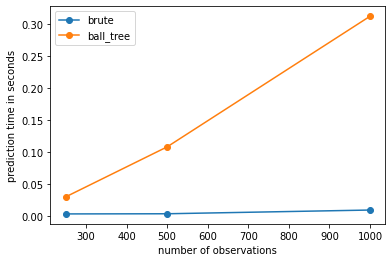

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of observations")
ax.set_ylabel("prediction time in seconds")
ax.legend();

## Q2 : k-nn avec sparse features

On recommence cette mesure de temps mais en créant des jeux de données [sparses](https://fr.wikipedia.org/wiki/Matrice_creuse). On utilise le jeu précédent et on lui adjoint des coordonnées aléatoires et sparse. La première fonction ``random_sparse_matrix`` crée un vecteur sparse.

In [15]:
import numpy
import numpy.random
import random
import scipy.sparse


def random_sparse_matrix(shape, ratio_sparse=0.2):
    rnd = numpy.random.rand(shape[0] * shape[1])
    sparse = 0
    for i in range(0, len(rnd)):
        x = random.random()
        if x <= ratio_sparse - sparse:
            sparse += 1 - ratio_sparse
        else:
            rnd[i] = 0
            sparse -= ratio_sparse
    rnd.resize(shape[0], shape[1])
    return scipy.sparse.csr_matrix(rnd)


mat = random_sparse_matrix((20, 20))
"% non null coefficient", 1. * mat.nnz / (mat.shape[0] * mat.shape[1]), "shape", mat.shape

('% non null coefficient', 0.2, 'shape', (20, 20))

In [16]:
import random
from scipy.sparse import hstack

def what_to_measure_sparse(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute", nb_sparse=20, ratio_sparse=0.2):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    
    sp = random_sparse_matrix((datax.shape[0], (nb_sparse - n_features)), ratio_sparse=ratio_sparse)
    datax = hstack([datax, sp])
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(datax, datay)
    t1 = time.perf_counter()
    y = model.predict(datax)
    t2 = time.perf_counter()
    return t2 - t1, y, datax.nnz / (datax.shape[0] * datax.shape[1])

In [18]:
dt, y, sparse_ratio = what_to_measure_sparse(Nobs, 10, nb_sparse=100, ratio_sparse=0.2)
dt, sparse_ratio

(0.09028749999924912, 0.28)

Seul l'algorithme *brute* accepte les features sparses.

In [19]:
from tqdm import tqdm

x = []
y = []
nfd = 200
for nf in nf_set:
    x.append(nf)
    dt, _, ratio = what_to_measure_sparse(Nobs, n_features=nf, nb_sparse=nfd+nf, 
                                   ratio_sparse=1.*nfd/(nfd+nf))
    y.append(dt)
    print("nf={0} dt={1} ratio={2}".format(nf, dt, ratio))

 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

nf=10 dt=3.568506300000081 ratio=0.9546476190476191


 40%|████      | 2/5 [00:07<00:10,  3.65s/it]

nf=20 dt=3.6447933999997986 ratio=0.9173545454545454


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

nf=50 dt=3.9383225999999922 ratio=0.84


 80%|████████  | 4/5 [00:15<00:04,  4.15s/it]

nf=100 dt=4.616280500000357 ratio=0.77778


100%|██████████| 5/5 [00:24<00:00,  4.80s/it]

nf=200 dt=7.977762700000312 ratio=0.75


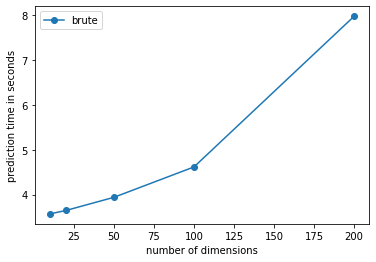

In [20]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.set_xlabel("number of dimensions")
ax.set_ylabel("prediction time in seconds")
ax.legend();

La dimension augmente mais le nombre de features non nulle est constant. Comme l'algorithme est fortement dépendant de la distance entre deux éléments et le coût de cette distance dépend du nombre de coefficients non nuls.

## Q3 : Imaginez une façon d'aller plus vite ?

Le coût d'un algorithme des plus proches voisins est linéaire selon la dimension car la majeure partie du temps est passé dans la fonction de distance et que celle-ci est linéaire. Mesurons la performance en fonction de la dimension. Ce n'est pas vraiment rigoureux de le faire dans la mesure où les données changent et n'ont pas les mêmes propriétés mais cela donnera une idée.

In [21]:
from sklearn.model_selection import train_test_split

def what_to_measure_perf(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    X_train, X_test, y_train, y_test = train_test_split(datax, datay)
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    y = model.predict(X_test)
    t2 = time.perf_counter()
    good = (y_test == y).sum() / len(datay)
    return t2 - t1, good

what_to_measure_perf(Nobs, 100)

(0.003669900000204507, 0.158)

In [22]:
x = []
y = []
for nf in nf_set:
    x.append(nf)
    dt, perf = what_to_measure_perf(Nobs, n_features=nf)
    y.append(perf)
    print("nf={0} perf={1} dt={2}".format(nf, perf, dt))

nf=10 perf=0.2 dt=0.0022122999998828163
nf=20 perf=0.21 dt=0.0009547999998176238
nf=50 perf=0.182 dt=0.0017370000005030306
nf=100 perf=0.184 dt=0.00210730000071635
nf=200 perf=0.158 dt=0.003134900000077323


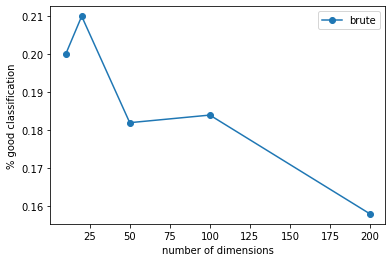

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.set_xlabel("number of dimensions")
ax.set_ylabel("% good classification")
ax.legend();

Même si les performances ne sont pas tout-à-fait comparables, il est vrai qu'il est plus difficile de construire un classifieur basé sur une distance en grande dimension. La raison est simple : plus il y a de dimensions, plus la distance devient binaire : soit les coordonnées concordent sur les mêmes dimensions, soit elles ne concordent pas et la distance est presque équivalente à la somme des carrés des coordonnées.

Revenons au problème principal. Accélérer le temps de calcul des plus proches voisins.
L'idée est d'utiliser une [ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) : l'ACP a la propriété de trouver un hyperplan qui réduit les dimensions mais qui conserve le plus possible l'inertie d'un nuage de points et on l'exprimer ainsi :

$$I = \frac{1}{n} \sum_i^n \left\Vert X_i - G \right\Vert^2 = \frac{1}{n^2} \sum_i^n\sum_j^n \left\Vert X_i - X_j \right\Vert^2$$

Bref, l'ACP conserve en grande partie les distances. Cela veut dire qu'une ACP réduit les dimensions, donc le temps de prédiction, tout en conservant le plus possible la distance entre deux points.

In [25]:
from sklearn.decomposition import PCA

def what_to_measure_perf_acp(n, n_features, acp_dim=10,
                    n_classes=3,  n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    X_train, X_test, y_train, y_test = train_test_split(datax, datay)
    
    # sans ACP
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(X_train, y_train)
    t1o = time.perf_counter()
    y = model.predict(X_test)
    t2o = time.perf_counter()
    goodo = (y_test == y).sum() / len(datay)
    
    # ACP
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    pca = PCA(n_components=acp_dim)
    t0 = time.perf_counter()
    X_train_pca = pca.fit_transform(X_train)
    model.fit(X_train_pca, y_train)
    t1 = time.perf_counter()
    X_test_pca = pca.transform(X_test)
    y = model.predict(X_test_pca)
    t2 = time.perf_counter()
    good = (y_test == y).sum() / len(datay)
    
    return t2o - t1o, goodo, t2 - t1, t1 - t0, good

what_to_measure_perf_acp(500, 100)

(0.0022221999997782405,
 0.156,
 0.0010087999999086605,
 0.029213499999968917,
 0.17)

In [26]:
x = []
y = []
yp = []
p = []
p_noacp = []
y_noacp = []
for nf in nf_set:
    x.append(nf)
    dt_noacp, perf_noacp, dt, dt_train, perf = what_to_measure_perf_acp(Nobs, n_features=nf)
    p.append(perf)
    y.append(perf)
    yp.append(dt_train)
    y_noacp.append(dt_noacp)
    p_noacp.append(perf_noacp)
    print("nf={0} perf={1} dt_predict={2} dt_train={3}".format(nf, perf, dt, dt_train))

nf=10 perf=0.202 dt_predict=0.0020304999998188578 dt_train=0.0021592000002783607
nf=20 perf=0.192 dt_predict=0.0010569000005489215 dt_train=0.0015843000001041219
nf=50 perf=0.2 dt_predict=0.0009798000000955653 dt_train=0.002628299999742012
nf=100 perf=0.17 dt_predict=0.0023179999998319545 dt_train=0.013047299999925599
nf=200 perf=0.16 dt_predict=0.0009872000000541448 dt_train=0.018462199999703444


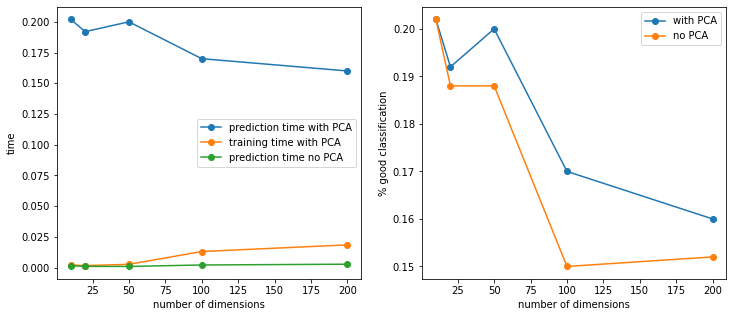

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(x, y, "o-", label="prediction time with PCA")
ax[0].plot(x, yp, "o-", label="training time with PCA")
ax[0].plot(x, y_noacp, "o-", label="prediction time no PCA")
ax[0].set_xlabel("number of dimensions")
ax[0].set_ylabel("time")
ax[1].plot(x, p, "o-", label="with PCA")
ax[1].plot(x, p_noacp, "o-", label="no PCA")
ax[1].set_xlabel("number of dimensions")
ax[1].set_ylabel("% good classification")
ax[0].legend()
ax[1].legend();

Etonnament, l'ACP améliore les performances du modèle en terme de prédiction. Cela suggère que les données sont bruitées et que l'ACP en a réduit l'importance. Le calcul de l'ACP est linéaire par rapport au nombre de features. Une partie des coûts a été transférée sur l'apprentissage et le prédiction est constant car on conseerve toujours le même nombre de dimensions.